In [1]:
version = 'v20250521'

import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np


## SNR for series

In [2]:
srs = pd.read_parquet(f'./metric/srs_predicted_{version}.pq')
srs = srs[srs.columns[0:21].tolist()+srs.columns[-24::].tolist()]

In [3]:
# get the snr for both models
srs = srs.rename(columns={'snr':'snr_pnt','noise':'noise_pnt','pred_std':'noise_srs'})
srs['snr_srs'] = srs['signal']/srs['noise_srs']

# only examine land cover series with population>30
vc = srs['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
srs = srs.loc[srs['lc_str'].isin(lcl)]

In [4]:
# plot in order
lc_order = [
    'Crop-Crop-Crop', 'Grass-Grass-Grass', 'Wood-Wood-Wood', # no lc change
    'Crop-Crop-Bare', 'Grass-Crop-Crop', # decreasing veg
    'Crop-Grass-Grass', 'Crop-Crop-Grass' # increasing veg
]

# Set lc_str as categorical with the desired order
srs['lc_str'] = pd.Categorical(srs['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['Crop-Crop-Crop', 'Grass-Grass-Grass', 'Wood-Wood-Wood']
decreasing = ['Crop-Crop-Bare', 'Grass-Crop-Crop']
increasing = ['Crop-Grass-Grass', 'Crop-Crop-Grass']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color


In [5]:
# prepare data for plotting
def compute_summary(df, value_col, group_col='lc_str'):
    grouped = df.groupby(group_col)[value_col]
    summary = grouped.agg([
        'mean',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ])
    summary.columns = ['mean', 'q20', 'q80']
    summary['err_low'] = summary['mean'] - summary['q20']
    summary['err_high'] = summary['q80'] - summary['mean']
    return summary

# Compute summaries
signal_stats = compute_summary(srs, 'signal')
noise_stats = pd.concat([
    compute_summary(srs, 'noise_srs').assign(type='noise_srs'),
    compute_summary(srs, 'noise_pnt').assign(type='noise_pnt')
])
snr_stats = pd.concat([
    compute_summary(srs, 'snr_srs').assign(type='snr_srs'),
    compute_summary(srs, 'snr_pnt').assign(type='snr_pnt')
])

# Reset index for plotting
noise_stats = noise_stats.reset_index()
snr_stats = snr_stats.reset_index()
signal_stats = signal_stats.reset_index()

# Create color list for bars in top plot
bar_colors = [color_map[lc] for lc in signal_stats['lc_str']]

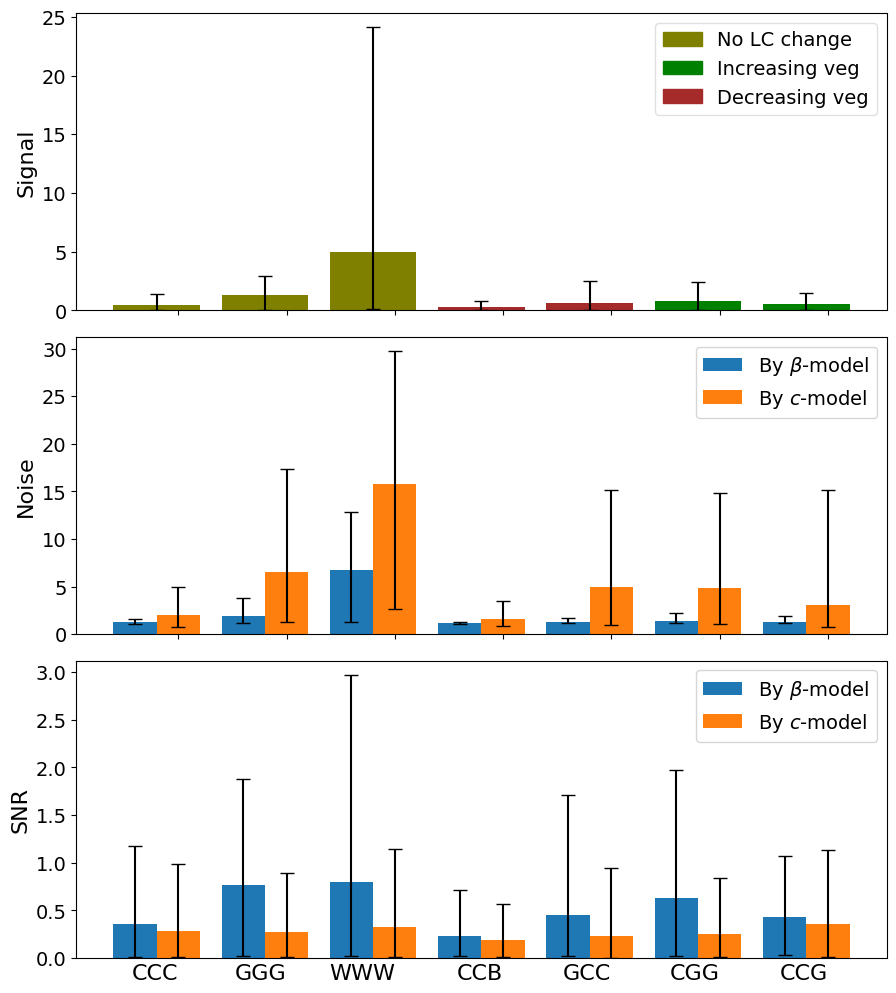

In [6]:
import matplotlib.pyplot as plt

x = np.arange(len(lc_order))
bar_width = 0.4

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 10), sharex=True)

# === Top: Signal (colored by land cover change group) ===
axs[0].bar(x, signal_stats['mean'], 
           yerr=[signal_stats['err_low'], signal_stats['err_high']],
           capsize=5, color=bar_colors, width=bar_width*2)  
axs[0].set_ylabel('Signal', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)

# Custom legend for LC change
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
axs[0].legend(handles=[olive_patch, green_patch, brown_patch],
              fontsize=14, framealpha=0.6, loc='upper right')

# === Middle: Noise (side-by-side) ===
noise_srs = noise_stats[noise_stats['type'] == 'noise_srs']
noise_pnt = noise_stats[noise_stats['type'] == 'noise_pnt']

axs[1].bar(x - bar_width/2, noise_srs['mean'], 
           yerr=[noise_srs['err_low'], noise_srs['err_high']],
           capsize=5, width=bar_width, label=r'By $\beta$-model')
axs[1].bar(x + bar_width/2, noise_pnt['mean'], 
           yerr=[noise_pnt['err_low'], noise_pnt['err_high']],
           capsize=5, width=bar_width, label='By $c$-model')

axs[1].set_ylabel('Noise', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=14)

# === Bottom: SNR (side-by-side) ===
snr_srs = snr_stats[snr_stats['type'] == 'snr_srs']
snr_pnt = snr_stats[snr_stats['type'] == 'snr_pnt']

axs[2].bar(x - bar_width/2, snr_srs['mean'], 
           yerr=[snr_srs['err_low'], snr_srs['err_high']],
           capsize=5, width=bar_width, label=r'By $\beta$-model')
axs[2].bar(x + bar_width/2, snr_pnt['mean'], 
           yerr=[snr_pnt['err_low'], snr_pnt['err_high']],
           capsize=5, width=bar_width, label='By $c$-model')

axs[2].set_ylabel('SNR', fontsize=16)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].legend(fontsize=14)

# Set common x-ticks and labels
axs[2].set_xticks(x+0.2)
lc_order = [
    'CCC', 'GGG', 'WWW', # no lc change
    'CCB', 'GCC', # decreasing veg
    'CGG', 'CCG' # increasing veg
]
axs[2].set_xticklabels(lc_order, rotation=0, ha='right', fontsize=16)
axs[2].tick_params(axis='x', which='both', length=0)

plt.tight_layout()
plt.savefig('./figure/plot_series_analysis.pdf', bbox_inches='tight')
plt.show()

## SNR for pairs

In [7]:
pair = pd.read_parquet(f'./metric/pair_predicted_{version}.pq')


In [8]:
# get the snr for both models
pair['signal'] = pair['soc_change'].abs()
pair = pair.rename(columns={'pred_std':'noise_pair','time_pair_x':'time_pair','lc_survey_pair_y':'lc_survey_pair'})
pair = pair.drop(columns=['time_pair_y','lc_survey_pair_x'])
pair['snr_pair'] = pair['signal']/pair['noise_pair']
pair['lc_str'] = pair['lc_survey_pair'].str[0] + '-' + pair['lc_survey_pair'].str[1]

In [9]:
# only examine land cover series with population>30
vc = pair['lc_str'].value_counts()
lcl = vc[vc>30].index.tolist() 
pair = pair.loc[pair['lc_str'].isin(lcl)]

In [10]:
# plot in order
lc_order = [
    'Cropland-Cropland','Grassland-Grassland','Woodland-Woodland','Shrubland-Shrubland',
    'Cropland-Bareland','Grassland-Cropland','Woodland-Grassland',
    'Bareland-Cropland','Cropland-Grassland','Shrubland-Woodland','Grassland-Woodland'
]

# Set lc_str as categorical with the desired order
pair['lc_str'] = pd.Categorical(pair['lc_str'], categories=lc_order, ordered=True)

import matplotlib.patches as mpatches

# Define land cover change groups
no_change = ['Cropland-Cropland','Grassland-Grassland','Woodland-Woodland','Shrubland-Shrubland']
decreasing = ['Cropland-Bareland','Grassland-Cropland','Woodland-Grassland']
increasing = ['Bareland-Cropland','Cropland-Grassland','Shrubland-Woodland','Grassland-Woodland']

# Map lc_str to colors
color_map = {}
for lc in lc_order:
    if lc in no_change:
        color_map[lc] = 'olive'
    elif lc in decreasing:
        color_map[lc] = 'brown'
    elif lc in increasing:
        color_map[lc] = 'green'
    else:
        color_map[lc] = 'gray'  # fallback color


In [11]:
# prepare data for plotting
def compute_summary(df, value_col, group_col='lc_str'):
    grouped = df.groupby(group_col)[value_col]
    summary = grouped.agg([
        'mean',
        lambda x: x.quantile(0.05),
        lambda x: x.quantile(0.95)
    ])
    summary.columns = ['mean', 'q10', 'q90']
    summary['err_low'] = summary['mean'] - summary['q10']
    summary['err_high'] = summary['q90'] - summary['mean']
    return summary

# Compute summaries
signal_stats = compute_summary(pair, 'signal')
noise_stats = pd.concat([
    compute_summary(pair, 'noise_pair').assign(type='noise_pair'),
    compute_summary(pair, 'noise_pnt').assign(type='noise_pnt')
])
snr_stats = pd.concat([
    compute_summary(pair, 'snr_pair').assign(type='snr_pair'),
    compute_summary(pair, 'snr_pnt').assign(type='snr_pnt')
])

# Reset index for plotting
noise_stats = noise_stats.reset_index()
snr_stats = snr_stats.reset_index()
signal_stats = signal_stats.reset_index()

# Create color list for bars in top plot
bar_colors = [color_map[lc] for lc in signal_stats['lc_str']]

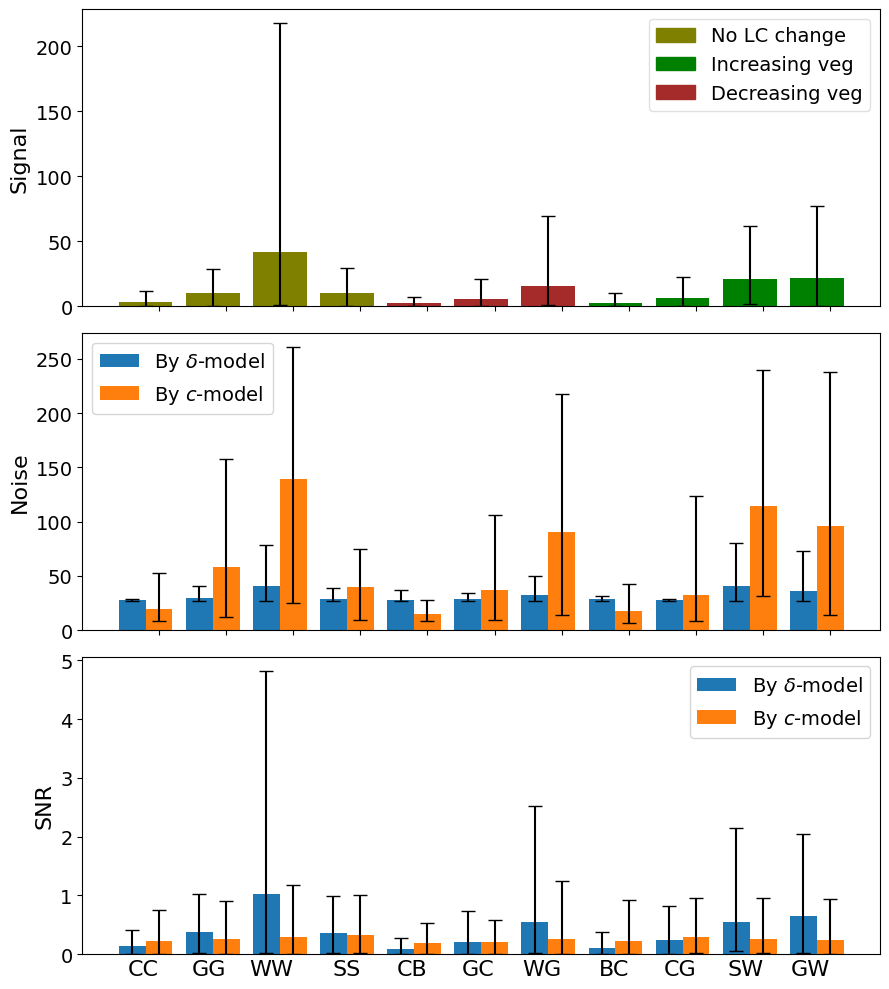

In [12]:
import matplotlib.pyplot as plt

x = np.arange(len(lc_order))
bar_width = 0.4

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(9, 10), sharex=True)

# === Top: Signal (colored by land cover change group) ===
axs[0].bar(x, signal_stats['mean'], 
           yerr=[signal_stats['err_low'], signal_stats['err_high']],
           capsize=5, color=bar_colors, width=bar_width*2)  
axs[0].set_ylabel('Signal', fontsize=16)
axs[0].tick_params(axis='both', labelsize=14)

# Custom legend for LC change
olive_patch = mpatches.Patch(color='olive', label='No LC change')
green_patch = mpatches.Patch(color='green', label='Increasing veg')
brown_patch = mpatches.Patch(color='brown', label='Decreasing veg')
axs[0].legend(handles=[olive_patch, green_patch, brown_patch],
              fontsize=14, framealpha=0.6, loc='upper right')

# === Middle: Noise (side-by-side) ===
noise_pair = noise_stats[noise_stats['type'] == 'noise_pair']
noise_pnt = noise_stats[noise_stats['type'] == 'noise_pnt']

axs[1].bar(x - bar_width/2, noise_pair['mean'], 
           yerr=[noise_pair['err_low'], noise_pair['err_high']],
           capsize=5, width=bar_width, label=r'By $\delta$-model')
axs[1].bar(x + bar_width/2, noise_pnt['mean'], 
           yerr=[noise_pnt['err_low'], noise_pnt['err_high']],
           capsize=5, width=bar_width, label='By $c$-model')

axs[1].set_ylabel('Noise', fontsize=16)
axs[1].tick_params(axis='both', labelsize=14)
axs[1].legend(fontsize=14)

# === Bottom: SNR (side-by-side) ===
snr_pair = snr_stats[snr_stats['type'] == 'snr_pair']
snr_pnt = snr_stats[snr_stats['type'] == 'snr_pnt']

axs[2].bar(x - bar_width/2, snr_pair['mean'], 
           yerr=[snr_pair['err_low'], snr_pair['err_high']],
           capsize=5, width=bar_width, label=r'By $\delta$-model')
axs[2].bar(x + bar_width/2, snr_pnt['mean'], 
           yerr=[snr_pnt['err_low'], snr_pnt['err_high']],
           capsize=5, width=bar_width, label='By $c$-model')

axs[2].set_ylabel('SNR', fontsize=16)
axs[2].tick_params(axis='both', labelsize=14)
axs[2].legend(fontsize=14)

# Set common x-ticks and labels
axs[2].set_xticks(x+0.2)
lc_order = [
    'CC','GG','WW','SS',
    'CB','GC','WG',
    'BC','CG','SW','GW'
]
axs[2].set_xticklabels(lc_order, rotation=0, ha='right', fontsize=16)
axs[2].tick_params(axis='x', which='both', length=0)

plt.tight_layout()
plt.savefig('./figure/plot_pair_analysis.pdf', bbox_inches='tight')
plt.show()